In [17]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [18]:
import torch 
import torch.nn as nn

import numpy as np
from time import time
import torch.quantization
from torch.quantization import QuantStub, DeQuantStub

from PIL import Image
from resources.MODNet.src.models.modnet import MODNet
from resources.MODNet.inference.image_matting.inference_class import InfernceIMG

pretrained_ckpt = '../../resources/MODNet/pretrained/modnet_photographic_portrait_matting.ckpt'

#/home/dev/work_main/courses/Efficient-DL-Models/

# model: https://github.com/ZHKKKe/MODNet/tree/master

os.path.isfile(pretrained_ckpt)

True

In [19]:
weights = torch.load(pretrained_ckpt,  map_location=torch.device('cpu'))

model = MODNet(backbone_pretrained=False)
model.load_state_dict(weights)


<All keys matched successfully>

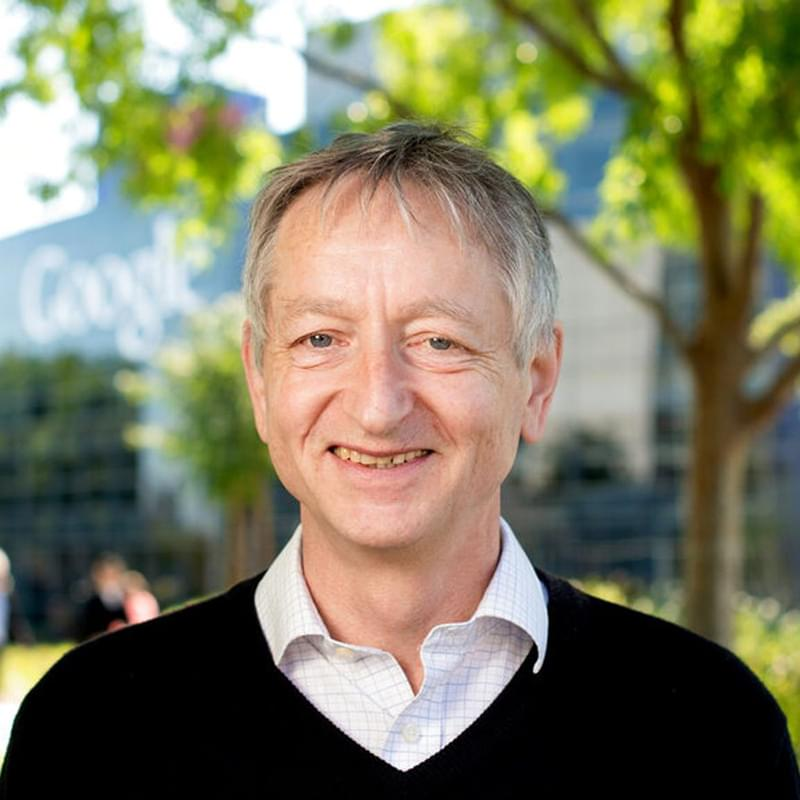

In [20]:
original_image = Image.open('data/input/hinton.jpg')
original_image

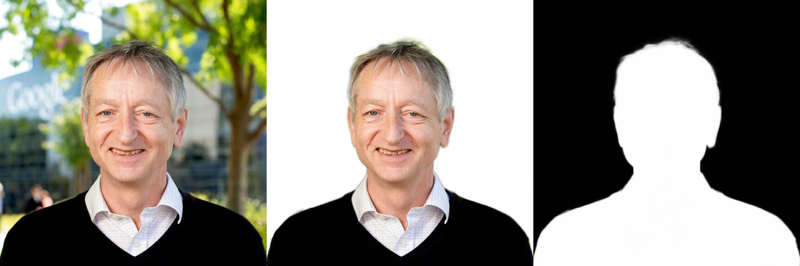

In [21]:
inferer = InfernceIMG(device='cpu')

matte =  inferer.transform(model, original_image)

combined, foreground  = inferer.combine(matte, original_image)

combined

In [22]:
def test_time(model, n=100, batch_size=1):

    time_total = np.zeros(shape=n)
    # run inference
    batch = torch.rand(batch_size,3,512,512)
    for i in range(n):
        start = time()
        with torch.no_grad():
            output = model(batch, True)
        end = time()
        time_total[i] = end - start
        
    print(f'execution time for model is: {time_total.mean():.4f} +/- {time_total.std():.4f}')

In [23]:
test_time(model, n=100)

In [32]:
class Qmodel(nn.Module):
    def __init__(self, base, q = False):
        # By turning on Q we can turn on/off the quantization
        super(Qmodel, self).__init__()
        self.q = q
        self.base = base
        if q:
          self.quant = QuantStub()
          self.dequant = DeQuantStub()

    def forward(self, x: torch.Tensor, inference) -> torch.Tensor:
        if self.q:
          x = self.quant(x)
          
          o1, o2, matte = self.base(x, inference)
        
        if self.q:
          matte = self.dequant(matte)
        return o1,o2, matte

In [34]:
from torch.ao.quantization import get_default_qconfig_mapping
from torch.ao.quantization import QConfigMapping
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx
from torch.quantization.observer import MovingAverageMinMaxObserver

base = MODNet(backbone_pretrained=False)
base.load_state_dict(weights)

qmodel = Qmodel(base, q=True)
qmodel.eval()


qmodel.qconfig =  torch.ao.quantization.get_default_qconfig('fbgemm')

prepared_model = torch.ao.quantization.prepare(qmodel, inplace=False)

In [35]:
matte =  inferer.transform(prepared_model, original_image)

prepared_model

Qmodel(
  (base): MODNet(
    (backbone): MobileNetV2Backbone(
      (model): MobileNetV2(
        (features): Sequential(
          (0): Sequential(
            (0): Conv2d(
              3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
              (activation_post_process): HistogramObserver(min_val=-10.092018127441406, max_val=8.733180046081543)
            )
            (1): BatchNorm2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (activation_post_process): HistogramObserver(min_val=-2.0340218544006348, max_val=3.3662421703338623)
            )
            (2): ReLU6(
              inplace=True
              (activation_post_process): HistogramObserver(min_val=0.0, max_val=3.3662421703338623)
            )
          )
          (1): InvertedResidual(
            (ff): FloatFunctional(
              (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
            )
            (conv): Sequent

In [36]:
qmodel_int8 = torch.ao.quantization.convert(prepared_model)
print(qmodel_int8)

Qmodel(
  (base): MODNet(
    (backbone): MobileNetV2Backbone(
      (model): MobileNetV2(
        (features): Sequential(
          (0): Sequential(
            (0): QuantizedConv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), scale=0.14598619937896729, zero_point=67, padding=(1, 1), bias=False)
            (1): QuantizedBatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): QuantizedReLU6(inplace=True)
          )
          (1): InvertedResidual(
            (ff): QFunctional(
              scale=1.0, zero_point=0
              (activation_post_process): Identity()
            )
            (conv): Sequential(
              (0): QuantizedConv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.09006185084581375, zero_point=65, padding=(1, 1), groups=32, bias=False)
              (1): QuantizedBatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): QuantizedReLU6(inplace=True)
              (3): Quantiz

In [26]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        test_time(model, n=100, batch_size=1)
        
print(prof.key_averages(group_by_stack_n=5).table(sort_by="self_cpu_time_total", row_limit=4))

STAGE:2024-09-10 02:24:53 125668:125668 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


execution time for model is: 0.1777 +/- 0.0654


STAGE:2024-09-10 02:25:11 125668:125668 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-09-10 02:25:11 125668:125668 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
        aten::mkldnn_convolution        51.72%        9.196s        52.29%        9.297s       1.347ms          6900  
         aten::native_batch_norm        18.46%        3.282s        19.10%        3.396s     404.317us          8400  
                 model_inference         7.51%        1.336s       100.00%       17.780s       17.780s             1  
       aten::upsample_bilinear2d         7.39%        1.314s         8.46%        1.505s       1.670ms           901  
--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
Self CPU time total: 17.780s



In [37]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        test_time(qmodel_int8, n=100, batch_size=1)

print(prof.key_averages(group_by_stack_n=5).table(sort_by="self_cpu_time_total", row_limit=4))

STAGE:2024-09-10 02:27:07 125668:125668 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


execution time for model is: 0.1620 +/- 0.0748


STAGE:2024-09-10 02:27:24 125668:125668 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-09-10 02:27:24 125668:125668 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                quantized::conv2d        32.43%        5.258s        37.07%        6.010s     871.070us          6900  
                      aten::clone        10.34%        1.677s        10.66%        1.728s     274.293us          6300  
                  model_inference         9.87%        1.601s       100.00%       16.214s       16.214s             1  
        aten::upsample_bilinear2d         9.79%        1.588s         9.84%        1.595s       1.772ms           900  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
Self CPU time total: 16.214s



In [44]:
compiled = torch.compile(qmodel_int8)

In [46]:
test_time(compiled, n=100, batch_size=1)

execution time for model is: 0.1765 +/- 0.1279


In [49]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        test_time(compiled, n=100, batch_size=4)

print(prof.key_averages(group_by_stack_n=5).table(sort_by="self_cpu_time_total", row_limit=4))

STAGE:2024-09-10 02:34:54 125668:125668 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


: 

In [39]:
torch.save(qmodel_int8.state_dict(), 'MODNet/pretrained/q_model.ckpt')

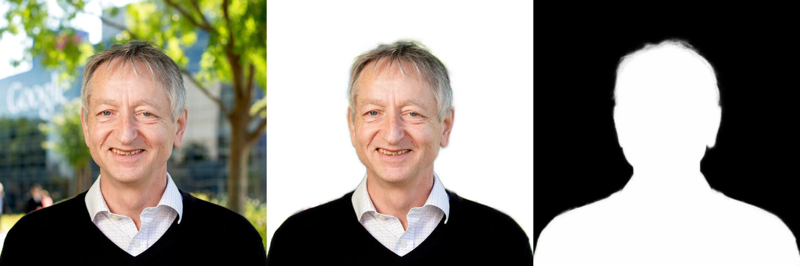

In [42]:
matte =  inferer.transform(compiled, original_image)

combined, foreground  = inferer.combine(matte, original_image)

combined